In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from utils.dataset_adaptors import MidogDatasetAdaptor, load_midog_df

### Load data

In [10]:
# set params
annotaton_file = 'annotations/MIDOG2022_training.csv'
img_dir = '/data/patho/MIDOG2'

train_df, val_df, _ = load_midog_df(annotations_file_path=annotaton_file)

### Check sample function

Lets check if our sample function covers an entire image. We create our dataset with a single image and let the sample function create multiple samples. We plot the coordinates on the image to see if we cover most areas of the image. 

In [99]:
from matplotlib import patches 

def plot_samples_on_image(
        filename: str, 
        df: pd.DataFrame, 
        fg_prob: float, 
        arb_prob: float, 
        num_samples: int, 
        patch_size: int, 
        ds: int = 16
        ):
    # choose single image 
    image_df = df.query('filename == @filename')

    # create dataset
    dataset = MidogDatasetAdaptor(
        img_dir_path=img_dir,
        dataset=image_df,
        num_samples=num_samples,
        patch_size=patch_size,
        fg_prob=fg_prob,
        arb_prob=arb_prob
    )
    
    # extract slide object
    slide = dataset.slide_objects[0]
    
    thumb_patch_size = slide.patch_size[0] // ds

    # create thumbnail
    thumb_width, thumb_height = slide.slide_size[0] // ds, slide.slide_size[1] // ds 
    thumb = slide.slide.get_thumbnail((thumb_width, thumb_height))

    # create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(thumb)
    ax.axis('off')

    # plot extracted coords on the thumbnail 
    for sample_id, sample in dataset.samples.items():
        x, y = sample['coords']
        x /= ds
        y /= ds 
        patch = patches.Rectangle(
            (x, y), thumb_patch_size, thumb_patch_size,
            linewidth=1, edgecolor='g', fill=None
            )
        ax.add_patch(patch)

    # plot annotations on the thumbnail 
    for idx, row in slide.annotations.iterrows():
        label, x1, y1, x2, y2 = row
        width = (x2-x1) / ds 
        height = (y2-y1) / ds
        x1 /= ds
        y1 /= ds 

        # mitotic figures = red, imposter = blue 
        color = 'r' if label == 0 else 'b'
        patch = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=3, edgecolor=color, fill=None
            )
        ax.add_patch(patch)

    plt.show()

In [165]:
# set params 
filename = '002.tiff'
fg_prob = 0.3
arb_prob = 0.4
num_samples = 256
patch_size = 1280
ds = 16

Initializing slides:   0%|          | 0/1 [00:00<?, ?it/s]

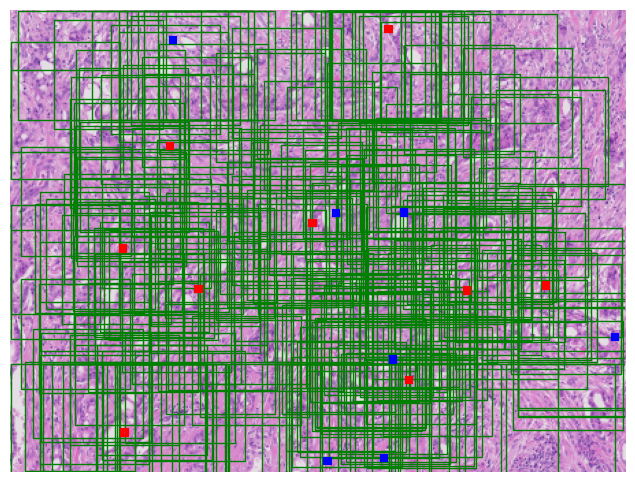

In [166]:
plot_samples_on_image(
    filename, train_df, 
    fg_prob=0.5, 
    arb_prob=0.25, 
    num_samples=num_samples, 
    patch_size=patch_size, ds=ds)

Initializing slides:   0%|          | 0/1 [00:00<?, ?it/s]

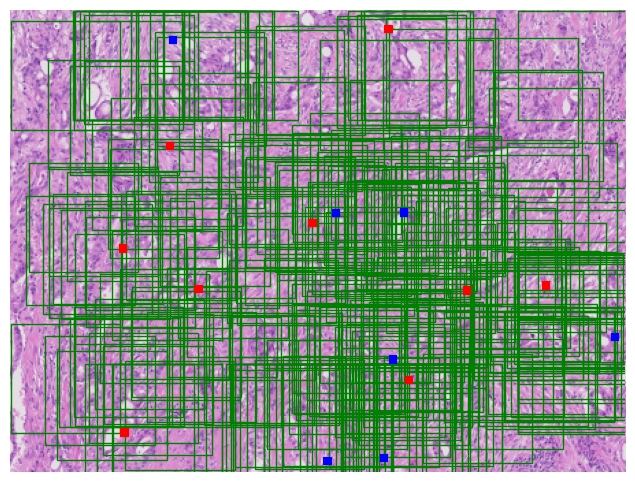

In [167]:
plot_samples_on_image(
    filename, train_df, 
    fg_prob=0.3, 
    arb_prob=0.4, 
    num_samples=num_samples, 
    patch_size=patch_size, ds=ds)

Initializing slides:   0%|          | 0/1 [00:00<?, ?it/s]

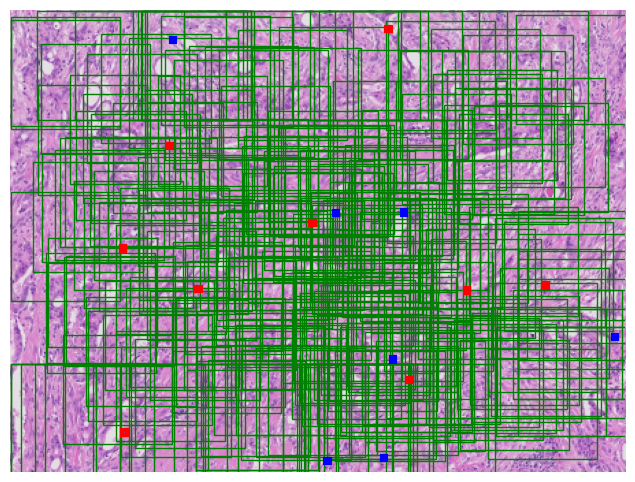

In [168]:
plot_samples_on_image(
    filename, train_df, 
    fg_prob=0.2, 
    arb_prob=0.6, 
    num_samples=num_samples, 
    patch_size=patch_size, ds=ds)

Initializing slides:   0%|          | 0/1 [00:00<?, ?it/s]

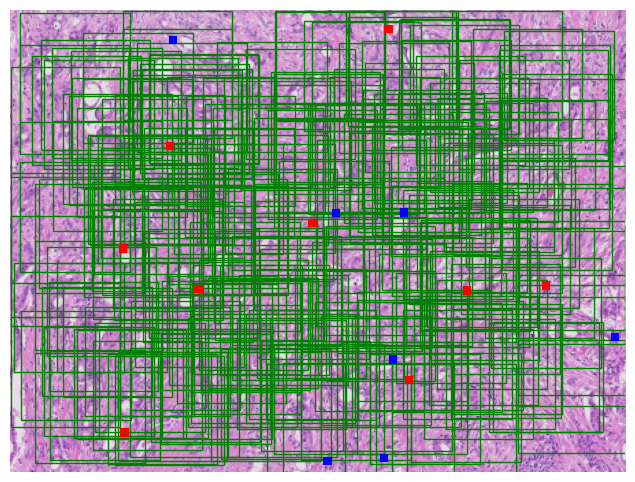

In [169]:
plot_samples_on_image(
    filename, train_df, 
    fg_prob=0., 
    arb_prob=1., 
    num_samples=num_samples, 
    patch_size=patch_size, ds=ds)

In [92]:
# choose single image 
image_df = train_df.query('filename == @filename')

# create dataset
dataset = MidogDatasetAdaptor(
    img_dir_path=img_dir,
    dataset=image_df,
    num_samples=num_samples,
    patch_size=patch_size,
    fg_prob=fg_prob,
    arb_prob=arb_prob
)

# extract slide object
slide = dataset.slide_objects[0]

Initializing slides:   0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
annos = slide.load_labels(label=0)
annos

array([[0., 0., 0., 0., 0.]], dtype=float32)

In [97]:
annos.any()

False